In [55]:
import pandas as pd
import dask.dataframe as dd
import os
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import dataframe_image as dfi

# Paths

In [47]:
processed_dir = os.path.join( "..", "data", "processed")

final_dataset_path = os.path.join(processed_dir, 'FEData_For_Modelling.parquet')

minority_users_dt_pq = os.path.join(processed_dir, 'minority_users_dt.parquet')
minority_users_smote_dt_pq = os.path.join(processed_dir, 'minority_users_dt_smote.parquet')

minority_users_svm_pq = os.path.join(processed_dir, 'minority_users_svm.parquet')
minority_users_smote_svm_pq = os.path.join(processed_dir, 'minority_users_svm_smote.parquet')

minority_users_nn_pq = os.path.join(processed_dir, 'minority_users_nn.parquet')
minority_users_smote_nn_pq = os.path.join(processed_dir, 'minority_users_nn_smote.parquet')


# Figures
figures_dir = os.path.join( "..", "materials", "reports", "figures")

bar_graph_minority_path = os.path.join(figures_dir, 'bar_graph_minority.png')
bar_graph_minority_smote_path = os.path.join(figures_dir, 'bar_graph_minority_smote.png')

combined_metrics_path = os.path.join(figures_dir, 'combined_metrics.png')

roc_curves_smote_path = os.path.join(figures_dir, 'roc_curves_smote.png')
roc_curves_path = os.path.join(figures_dir, 'roc_curves.png')

Import Dataset

In [4]:
# Read the multi-part Parquet dataset
dt_data = dd.read_parquet(minority_users_dt_pq)
smote_dt_data = dd.read_parquet(minority_users_smote_dt_pq)

svm_data = dd.read_parquet(minority_users_svm_pq)
smote_svm_data = dd.read_parquet(minority_users_smote_svm_pq)

nn_data = dd.read_parquet(minority_users_nn_pq)
smote_nn_data = dd.read_parquet(minority_users_smote_nn_pq)

dt_data.head(4000)

,user,Actual,Prediction,Decision Path,GINI Confidence of Prediction,normal_prob,malicious_prob
0,VAH1292,False,False,"[0, 1, 2, 4]",1.110223e-16,0.925581,0.074419
1,CJL0143,False,False,"[0, 1, 2, 3]",1.712135e-01,0.996160,0.003840
2,MMB1967,False,False,"[0, 1, 2, 3]",1.712135e-01,0.996160,0.003840
3,IVS1411,False,False,"[0, 1, 2, 3]",1.712135e-01,0.996160,0.003840
4,MEB1743,False,False,"[0, 1, 2, 4]",1.110223e-16,0.925581,0.074419
...,...,...,...,...,...,...,...
395,JIG1593,False,False,"[0, 1, 2, 3]",1.712135e-01,0.996160,0.003840
396,MDL0294,False,False,"[0, 1, 2, 3]",1.712135e-01,0.996160,0.003840
397,SSG0726,False,False,"[0, 1, 2, 3]",1.712135e-01,0.996160,0.003840
398,BWJ1539,False,False,"[0, 1, 5, 6]",5.350830e-01,0.968254,0.031746


# Calculations

In [6]:
def get_confusion_matrix_score(data):
    TN = len(data[(data['Actual'] == False) & (data['Prediction'] == False)])
    FP = len(data[(data['Actual'] == False) & (data['Prediction'] == True)])
    FN = len(data[(data['Actual'] == True) & (data['Prediction'] == False)])
    TP = len(data[(data['Actual'] == True) & (data['Prediction'] == True)])
    return TN, FP, FN, TP

get_confusion_matrix_score(dt_data)

(396, 0, 4, 0)

In [34]:
def get_model_scores_df(dt_data, svm_data, ae_data):
    model_scores = pd.DataFrame(columns = ['TN', 'FP', 'FN', 'TP'])
    model_data = [dt_data, svm_data, nn_data]

    for data in model_data:
        TN, FP, FN, TP = get_confusion_matrix_score(data)
        model_scores.loc[len(model_scores.index)] = [TN, FP, FN, TP]

    model_scores.index = ['Decision Tree', 'SVM', 'Autoencoder']
    return model_scores

model_scores_df = get_model_scores_df(dt_data, svm_data, nn_data)
smote_model_scores_df = get_model_scores_df(smote_dt_data, smote_svm_data, smote_nn_data)
smote_model_scores_df

,TN,FP,FN,TP
Decision Tree,387,9,2,2
SVM,395,1,4,0
Autoencoder,395,1,4,0


# Graph of Minority cases (FP/FN/TP) 

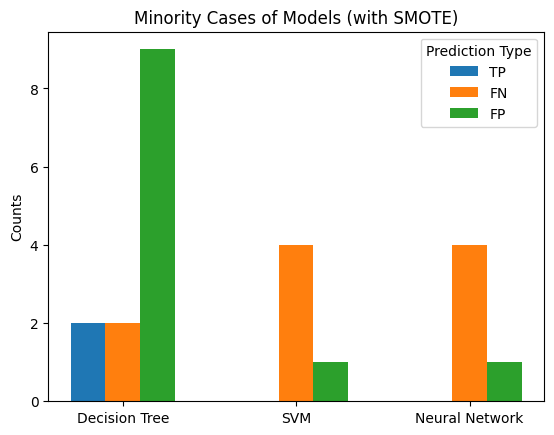

<Figure size 640x480 with 0 Axes>

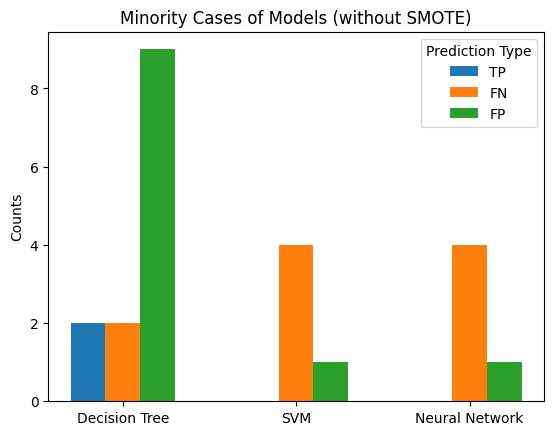

<Figure size 640x480 with 0 Axes>

In [48]:
models = ['Decision Tree', 'SVM', 'Neural Network']

selected_columns = ['TP', 'FN', 'FP']

def minority_plots(selected_columns, models, df, title, path):
    fig, ax = plt.subplots()
    for i, column in enumerate(selected_columns):
        ax.bar(
            x=[x + i * 0.2 for x in range(len(models))], 
            height=smote_model_scores_df[column], 
            width=0.2, 
            label=column
        )
    ax.set_xticks([x + 0.2 for x in range(len(models))])
    ax.set_xticklabels(models)
    ax.set_title(title)
    ax.set_ylabel('Counts')
    ax.legend(title="Prediction Type")
    plt.show()
    plt.savefig(path)

minority_plots(selected_columns, models, smote_model_scores_df, 'Minority Cases of Models (with SMOTE)', bar_graph_minority_smote_path)
minority_plots(selected_columns, models, model_scores_df, 'Minority Cases of Models (without SMOTE)', bar_graph_minority_path)


# Combined table of 'Accuracy', 'Precision', 'Recall', 'F1 Score'

In [56]:
def calculate_metrics(df):
    df['Accuracy'] = (df['TP'] + df['TN']) / (df['TN'] + df['FP'] + df['FN'] + df['TP'])
    df['Precision'] = df['TP'] / (df['TP'] + df['FP']).replace(0, 1)
    df['Recall'] = df['TP'] / (df['TP'] + df['FN']).replace(0, 1)
    df['F1 Score'] = 2 * (df['Precision'] * df['Recall']) / (df['Precision'] + df['Recall']).replace(0, 1)
    return df[['Accuracy', 'Precision', 'Recall', 'F1 Score']]
    
def generate_metrics_table(smote_df, no_smote_df, model_names):
    smote_metrics = calculate_metrics(smote_df)
    no_smote_metrics = calculate_metrics(no_smote_df)
    
    smote_metrics.index = [model + ' (SMOTE)' for model in model_names]
    no_smote_metrics.index = [model + ' (No SMOTE)' for model in model_names]
    
    metrics_table = pd.concat([no_smote_metrics, smote_metrics])
    return metrics_table

model_names = ['Decision Tree', 'SVM', 'Neural Network']
metrics_table = generate_metrics_table(smote_model_scores_df, model_scores_df, model_names)
dfi.export(metrics_table, combined_metrics_path)
metrics_table

,Accuracy,Precision,Recall,F1 Score
Decision Tree (No SMOTE),0.9900,0.000000,0.00,0.000000
SVM (No SMOTE),0.9925,1.000000,0.25,0.400000
Neural Network (No SMOTE),0.9875,0.000000,0.00,0.000000
Decision Tree (SMOTE),0.9725,0.181818,0.50,0.266667
SVM (SMOTE),0.9875,0.000000,0.00,0.000000
Neural Network (SMOTE),0.9875,0.000000,0.00,0.000000


# ROC Curve

In [19]:
def plot_roc_curve(true_y, y_prob, title, color):
    plt.figure(figsize=(8, 6))
    fpr, tpr, thresholds = roc_curve(true_y, y_prob)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=color, lw=2, label='ROC curve (area = %0.4f)' % roc_auc)
    plt.legend(loc="lower right")
    plt.title(title)

## ROC - For Decision Tree, SVM, Neural Network (without SMOTE)

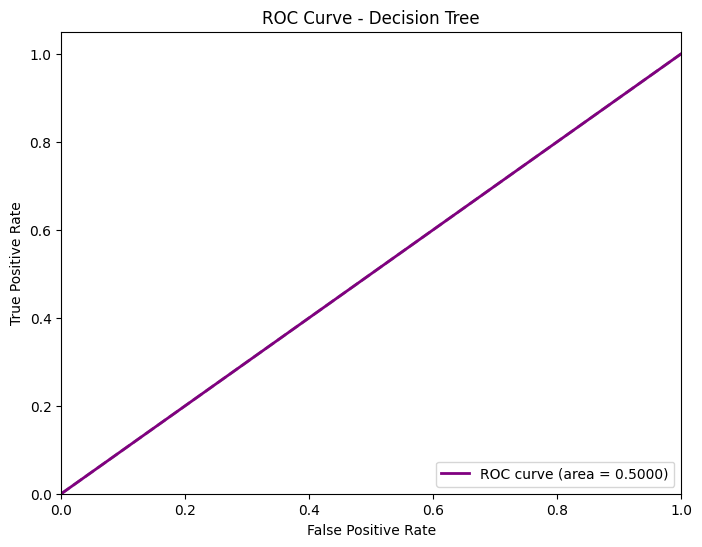

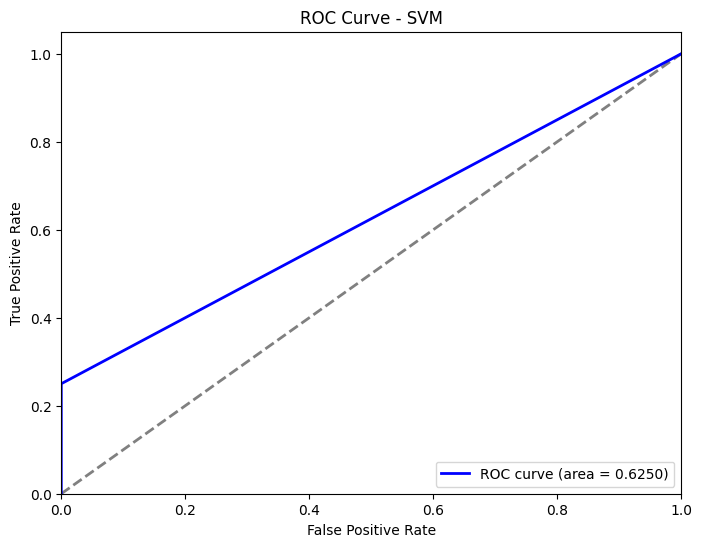

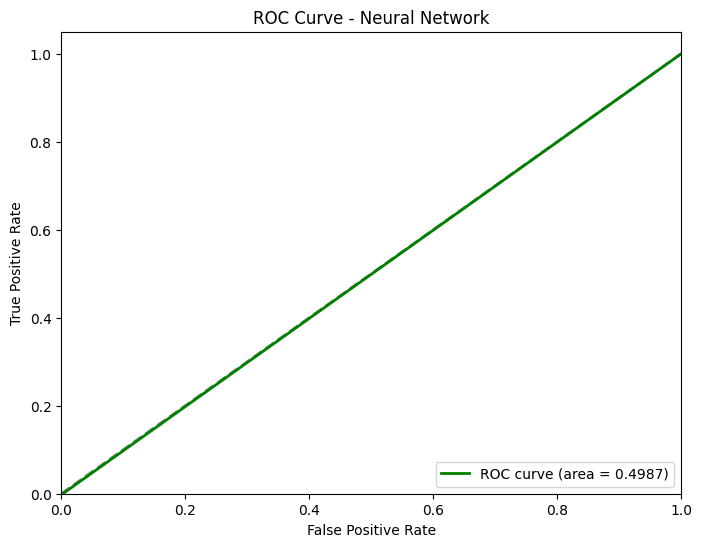

In [21]:
plot_roc_curve(dt_data["Actual"], dt_data["Prediction"], "ROC Curve - Decision Tree", 'purple')
plot_roc_curve(svm_data["Actual"], svm_data["Prediction"], "ROC Curve - SVM", 'blue')
plot_roc_curve(nn_data["Actual"], nn_data["Prediction"], "ROC Curve - Neural Network", 'green')

## ROC - For Decision Tree, SVM, Neural Network (with SMOTE)

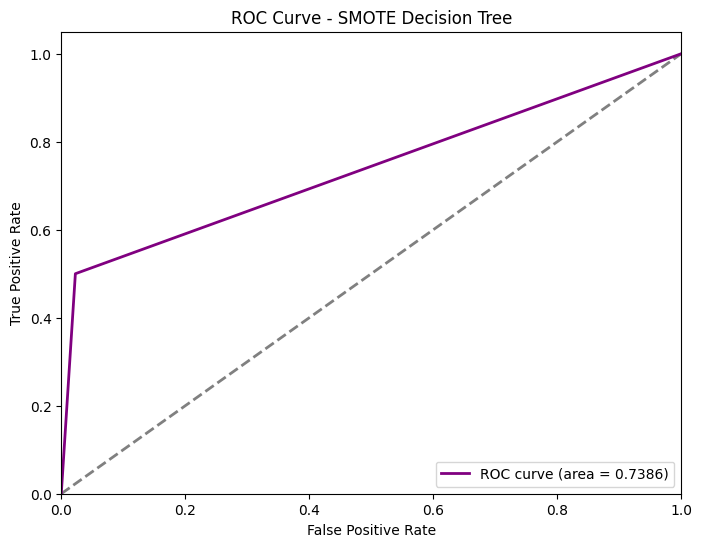

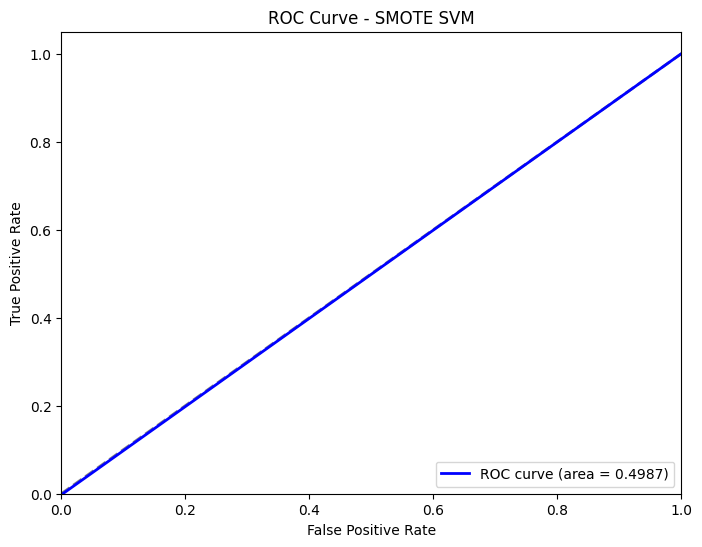

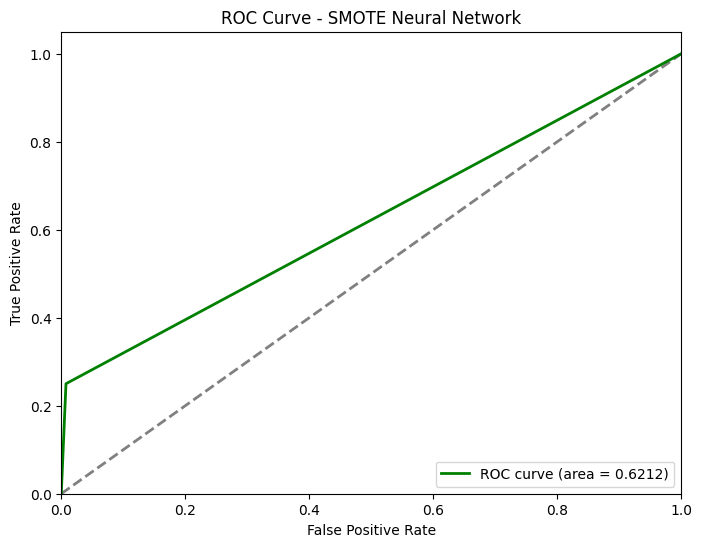

In [22]:
plot_roc_curve(smote_dt_data["Actual"], smote_dt_data["Prediction"], "ROC Curve - SMOTE Decision Tree", 'purple')
plot_roc_curve(smote_svm_data["Actual"], smote_svm_data["Prediction"], "ROC Curve - SMOTE SVM", 'blue')
plot_roc_curve(smote_nn_data["Actual"], smote_nn_data["Prediction"], "ROC Curve - SMOTE Neural Network", 'green')

## Collated ROC Curve Plots

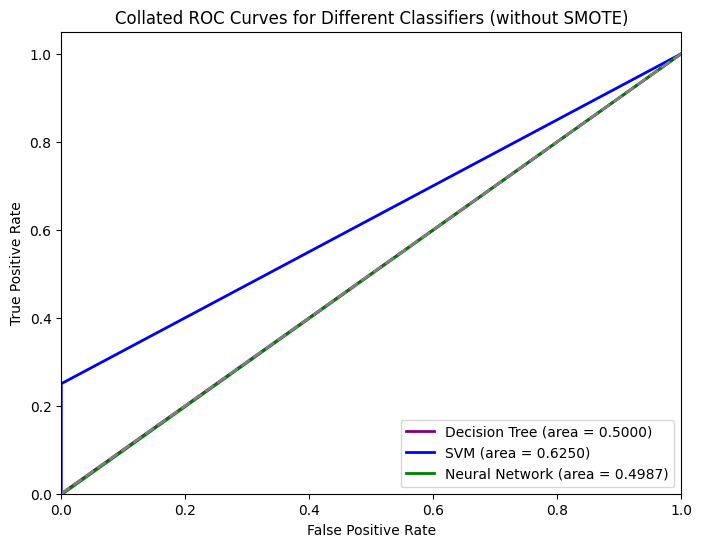

<Figure size 640x480 with 0 Axes>

In [53]:
def plot_roc_curve(true_y, y_prob, title, color):
    fpr, tpr, thresholds = roc_curve(true_y, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=color, lw=2, label='%s (area = %0.4f)' % (title, roc_auc))

plt.figure(figsize=(8, 6))

plot_roc_curve(dt_data["Actual"], dt_data["Prediction"], "Decision Tree", 'purple')
plot_roc_curve(svm_data["Actual"], svm_data["Prediction"], "SVM", 'blue')
plot_roc_curve(nn_data["Actual"], nn_data["Prediction"], "Neural Network", 'green')

plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title('Collated ROC Curves for Different Classifiers (without SMOTE)')
plt.show()
plt.savefig(roc_curves_path)

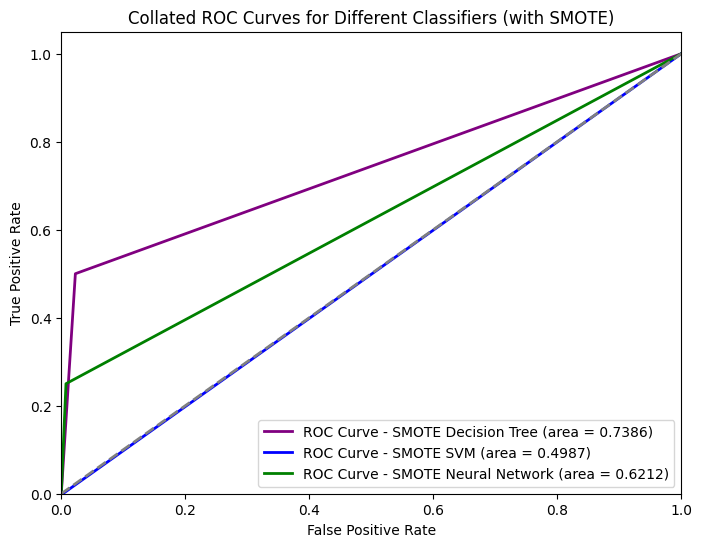

<Figure size 640x480 with 0 Axes>

In [52]:
plt.figure(figsize=(8, 6))

plot_roc_curve(smote_dt_data["Actual"], smote_dt_data["Prediction"], "ROC Curve - SMOTE Decision Tree", 'purple')
plot_roc_curve(smote_svm_data["Actual"], smote_svm_data["Prediction"], "ROC Curve - SMOTE SVM", 'blue')
plot_roc_curve(smote_nn_data["Actual"], smote_nn_data["Prediction"], "ROC Curve - SMOTE Neural Network", 'green')

plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title('Collated ROC Curves for Different Classifiers (with SMOTE)')
plt.show()
plt.savefig(roc_curves_smote_path)